# **W207 - Final Project**
# **Incident management process - completion time prediction**

Team 4:  Dicky Woo, Joy First, Da-Qi Ren

[Incident management process enriched event log dataset](https://archive.ics.uci.edu/ml/datasets/Incident+management+process+enriched+event+log)

**Project Overview**

*Joy to complete*

Attribute Information *(to be moved to appendix before submission)*:

1. number: incident identifier (24,918 different values);
2. incident state: eight levels controlling the incident management process transitions from opening until closing the case;
3. active: boolean attribute that shows whether the record is active or closed/canceled;
4. reassignment_count: number of times the incident has the group or the support analysts changed;
5. reopen_count: number of times the incident resolution was rejected by the caller;
6. sys_mod_count: number of incident updates until that moment;
7. made_sla: boolean attribute that shows whether the incident exceeded the target SLA;
8. caller_id: identifier of the user affected;
9. opened_by: identifier of the user who reported the incident;
10. opened_at: incident user opening date and time;
11. sys_created_by: identifier of the user who registered the incident;
12. sys_created_at: incident system creation date and time;
13. sys_updated_by: identifier of the user who updated the incident and generated the current log record;
14. sys_updated_at: incident system update date and time;
15. contact_type: categorical attribute that shows by what means the incident was reported;
16. location: identifier of the location of the place affected;
17. category: first-level description of the affected service;
18. subcategory: second-level description of the affected service (related to the first level description, i.e., to category);
19. u_symptom: description of the user perception about service availability;
20. cmdb_ci: (confirmation item) identifier used to report the affected item (not mandatory);
21. impact: description of the impact caused by the incident (values: 1â€“High; 2â€“Medium; 3â€“Low);
22. urgency: description of the urgency informed by the user for the incident resolution (values: 1â€“High; 2â€“Medium; 3â€“Low);
23. priority: calculated by the system based on 'impact' and 'urgency';
24. assignment_group: identifier of the support group in charge of the incident;
25. assigned_to: identifier of the user in charge of the incident;
26. knowledge: boolean attribute that shows whether a knowledge base document was used to resolve the incident;
27. u_priority_confirmation: boolean attribute that shows whether the priority field has been double-checked;
28. notify: categorical attribute that shows whether notifications were generated for the incident;
29. problem_id: identifier of the problem associated with the incident;
30. rfc: (request for change) identifier of the change request associated with the incident;
31. vendor: identifier of the vendor in charge of the incident;
32. caused_by: identifier of the RFC responsible by the incident;
33. close_code: identifier of the resolution of the incident;
34. resolved_by: identifier of the user who resolved the incident;
35. resolved_at: incident user resolution date and time (dependent variable);
36. closed_at: incident user close date and time (dependent variable)

**Exploratory Data Analysis**

*Da-Qi to complete*

*and adding additional column with completion time in hours (closed at - opened at)*

In [46]:
%matplotlib inline

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator
from matplotlib import cm
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml

# SK-learn libraries for learning.
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# SK-learn libraries for evaluation.
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report
from scipy.ndimage.filters import gaussian_filter
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# Tensorflow libraries 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
 

np.random.seed(0)
print ("OK")
import tensorflow as tf
print("Tensorflow version", tf.__version__)


OK
Tensorflow version 2.4.1


In [47]:
#importing the dataset (to be replaced with mount)
dataset = pd.read_csv ("incident_event_log.csv")
#dataset = pd.read_csv ("./drive/MyDrive/w207_final_project_First_Ren_Woo/incident_event_log.csv")
dataset.head ()
print(f"original dataset shape: {dataset.shape}")
print(dataset.head(6))


original dataset shape: (141712, 36)
       number incident_state  active  reassignment_count  reopen_count  \
0  INC0000045            New    True                   0             0   
1  INC0000045       Resolved    True                   0             0   
2  INC0000045       Resolved    True                   0             0   
3  INC0000045         Closed   False                   0             0   
4  INC0000047            New    True                   0             0   
5  INC0000047         Active    True                   1             0   

   sys_mod_count  made_sla    caller_id       opened_by        opened_at  ...  \
0              0      True  Caller 2403    Opened by  8  29/2/2016 01:16  ...   
1              2      True  Caller 2403    Opened by  8  29/2/2016 01:16  ...   
2              3      True  Caller 2403    Opened by  8  29/2/2016 01:16  ...   
3              4      True  Caller 2403    Opened by  8  29/2/2016 01:16  ...   
4              0      True  Caller 2403

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text major ticklabel objects>)

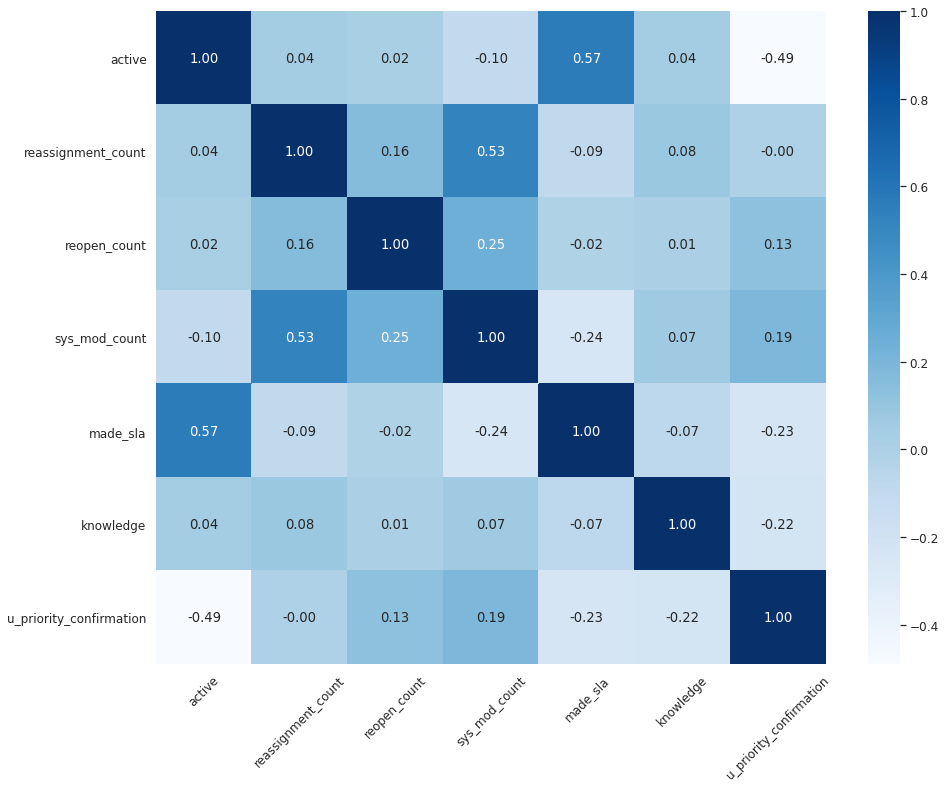

In [48]:
dataset.corr()
#sns.pairplot(dataset, hue = 'closed_time')
sns.set(font_scale=1.1)
plt.subplots(figsize=(15,12))
sns.heatmap(dataset.corr(), annot = True, fmt='.2f', cmap='Blues')
plt.xticks(rotation=45)


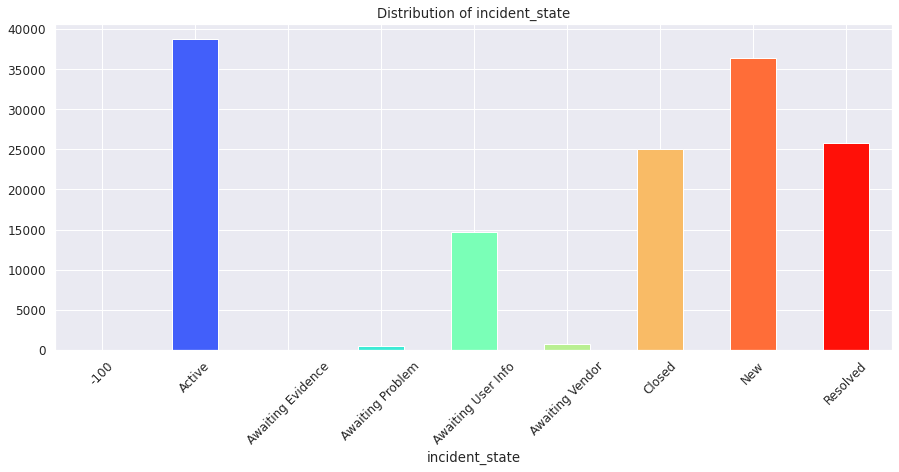

Active                38716
New                   36407
Resolved              25751
Closed                24985
Awaiting User Info    14642
Awaiting Vendor         707
Awaiting Problem        461
Awaiting Evidence        38
-100                      5
Name: incident_state, dtype: int64

In [49]:
# The distribution of incident_state. 
import matplotlib.cm as cm
dataset.groupby('incident_state').count()['number'].plot(kind='bar',
          title='Distribution of incident_state',
          color= cm.rainbow(np.linspace(0, 6)),
          figsize=(15, 6))
plt.xticks(rotation=45)
plt.show()
dataset['incident_state'].value_counts()

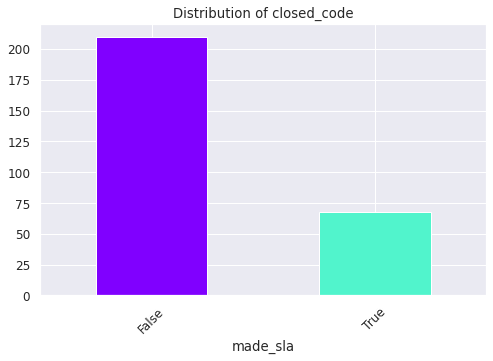

True     15831
False     9154
Name: made_sla, dtype: int64

In [50]:
# The ratio of SLA satisfactions among the closed cases. 

case_closed = dataset["incident_state"] == "Closed"
case_closed = dataset[case_closed]
case_closed_reopen = case_closed["reopen_count"] > 0
case_closed_reopen = case_closed[case_closed_reopen]

case_closed['made_sla'].value_counts()
case_closed_reopen['made_sla'].value_counts()
case_closed['u_symptom'].value_counts()
case_closed_reopen['u_symptom'].value_counts()


case_closed_reopen.groupby('made_sla').count()['number'].plot(kind='bar',
          title='Distribution of closed_code',
          color= cm.rainbow(np.linspace(0, 20)),
          figsize=(8, 5))
plt.xticks(rotation = 45) 
plt.show()
case_closed['made_sla'].value_counts()

In [51]:
#importing the dataset (to be replaced with mount)
#dataset = pd.read_csv ("incident_event_log.csv")
#dataset = pd.read_csv ("/content/drive/MyDrive/w207_final_project_First_Ren_Woo/incident_event_log.csv")
#dataset.head ()
#print(f"original dataset shape: {dataset.shape}")

# dropping features due missing values: problem ID, cmdb_CI, rfc, sys_created_by,sys_created_at,vendor,caused by
#dataset.drop (columns =["problem_id", "cmdb_ci","rfc", "sys_created_by","sys_created_at","vendor", "caused_by"], inplace=True)
#print(f"dataset shape after removing features: {dataset.shape}")

# removing "?" for the following features:category, subcategory, closed code, resolved by,location,caller id

#list = ['category','subcategory','closed_code','resolved_by','location','caller_id']
#for i in list:
#    dataset = dataset[dataset[i] != "?"]

#print(f"dataset shape after removing raws: {dataset.shape}")

# filtering by the following values (based on the data distribution and available records):
# *   incident_state = "Closed"
# *   contact_type = "Phone"
# *   priority = "3 - Moderate"
# *   urgency = "2 - Medium"
# *   impact = "2 - Medium"
# *   active = "False"

dataset = dataset[dataset['incident_state'] == "Closed"]
dataset = dataset[dataset['contact_type'] == "Phone"]
dataset = dataset[dataset['priority'] == "3 - Moderate"]
dataset = dataset[dataset['urgency'] == "2 - Medium"]
dataset = dataset[dataset['impact'] == "2 - Medium"]
#dataset = dataset[dataset['active'] == "False"]

print(f"dataset shape after filtering: {dataset.shape}")

# option 1 - with 19 features
# dataset.drop (columns =['incident_state', 'contact_type','priority', 'urgency','impact','active','opened_at','resolved_at','notify','closed_at', 'made_sla'], inplace=True)
# data cleansing and preparation


dataset shape after filtering: (23312, 36)


In [52]:
import warnings
warnings.filterwarnings('ignore')
 
# Preparation of the "limited dataset" - keeping only known features at the time of openning the ticket (excluding 'u_symptom' to avoid data loss)
#dataset_ml=dataset[['location','category','subcategory','caller_id','opened_by','assignment_group','assigned_to','u_priority_confirmation', 'processing_time','created_time','updated_time','resolved_time','made_sla']]

dataset = dataset[['location','category','subcategory','caller_id','opened_by','assignment_group','assigned_to','u_priority_confirmation', 'opened_at','sys_created_at','sys_updated_at','resolved_at', 'closed_at','made_sla']]

#print(f"dataset_ml shape after dropping additional features: {dataset_ml.shape}")

list = ['location','category','subcategory','caller_id','opened_by','assignment_group','assigned_to','u_priority_confirmation', 'opened_at','sys_created_at','sys_updated_at','resolved_at', 'closed_at','made_sla']

for i in list:
    dataset = dataset[dataset[i] != "?"]

dataset['closed_at'] = pd.to_datetime(dataset['closed_at'])
dataset['opened_at'] = pd.to_datetime(dataset['opened_at'])
dataset['sys_created_at'] = pd.to_datetime(dataset['sys_created_at'])
dataset['sys_updated_at'] = pd.to_datetime(dataset['sys_updated_at'])
dataset['resolved_at'] = pd.to_datetime(dataset['resolved_at'])
  
dataset['delta'] = dataset.closed_at - dataset.opened_at
dataset['processing_time'] = dataset['delta'].dt.total_seconds()/3600000
dataset['processing_time'] = dataset['processing_time'].round(1)

dataset['delta'] = dataset.sys_created_at - dataset.opened_at
dataset['created_time'] = dataset['delta'].dt.total_seconds()/3600
dataset['created_time'] = dataset['created_time'].round(1)

dataset['delta'] = dataset.sys_updated_at - dataset.opened_at
dataset['updated_time'] = dataset['delta'].dt.total_seconds()/3500000
dataset['updated_time'] = dataset['updated_time'].round(1)

dataset['delta'] = dataset.resolved_at - dataset.opened_at
dataset['resolved_time'] = dataset['delta'].dt.total_seconds()/3600000
dataset['resolved_time'] = dataset['resolved_time'].round(1)
dataset['resolved_time'] = np.where(dataset['resolved_time'] > 0, dataset['resolved_time'], 0)


dataset = dataset.drop(['delta','resolved_at', 'sys_updated_at','closed_at','opened_at'], axis=1)

dataset=dataset[['location','category','subcategory','caller_id','opened_by','assignment_group','assigned_to','u_priority_confirmation', 'processing_time','created_time','updated_time','resolved_time','made_sla']]

#print(dataset.head(6))
 
#print('dataset shape: ', dataset.shape)
print(f"dataset_ml shape after removing raws: {dataset.shape}")
 
print(dataset.head ())

dataset_ml shape after removing raws: (9873, 13)
        location     category      subcategory    caller_id       opened_by  \
12  Location 165  Category 40  Subcategory 215  Caller 2403  Opened by  397   
23  Location 204   Category 9   Subcategory 97  Caller 4491  Opened by  180   
48  Location 143  Category 53  Subcategory 168  Caller 2838  Opened by  131   
61  Location 108  Category 45   Subcategory 94  Caller 5323  Opened by  131   
76  Location 143   Category 9  Subcategory 110   Caller 442  Opened by  180   

   assignment_group   assigned_to  u_priority_confirmation  processing_time  \
12         Group 24   Resolver 89                    False              2.3   
23         Group 25  Resolver 125                    False              3.0   
48         Group 28   Resolver 78                    False              3.8   
61         Group 33  Resolver 216                    False              3.0   
76         Group 28  Resolver 236                    False              3.0   

 

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 <a list of 6 Text major ticklabel objects>)

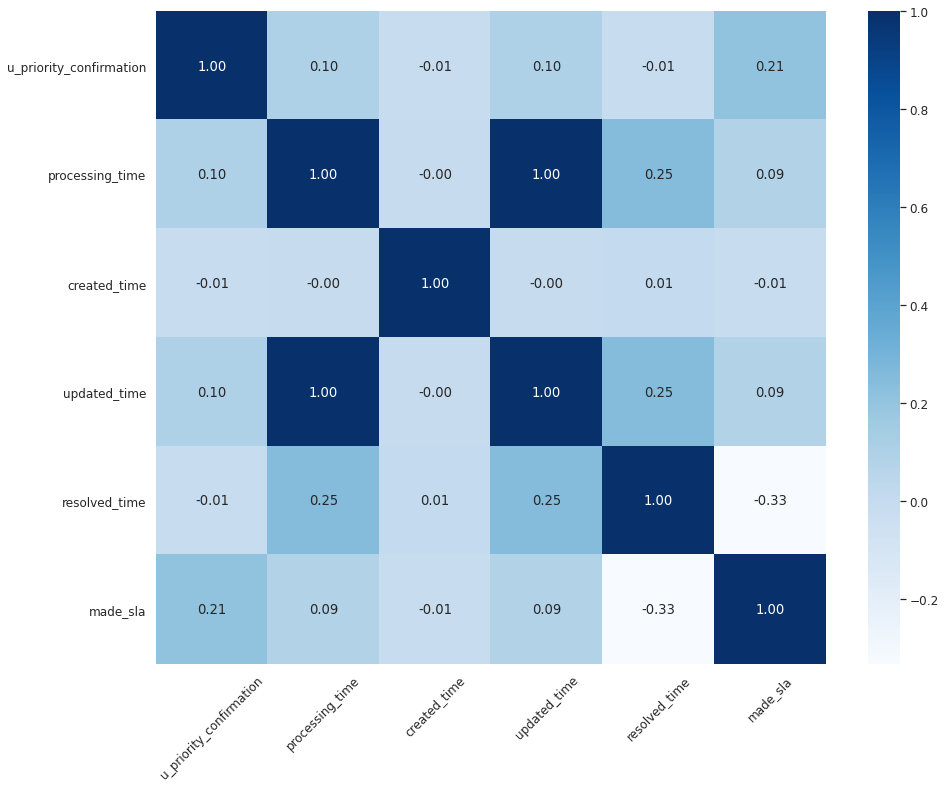

In [53]:
dataset.corr()
#sns.pairplot(dataset, hue = 'closed_time')
sns.set(font_scale=1.1)
plt.subplots(figsize=(15,12))
sns.heatmap(dataset.corr(), annot = True, fmt='.2f', cmap='Blues')
plt.xticks(rotation=45)


**Data Cleansing and Preparation Summary**

*Joy to complete*

In [54]:
#dimensonality reduction - could be included into a final submission - Joy? 
#  https://scikit-learn.org/stable/modules/feature_selection.html

In [55]:
# Joy - ML - predicting whether the ticket will be closed within the SLA

# Preparation of the "limited dataset" - keeping only known features at the time of openning the ticket (excluding 'u_symptom' to avoid data loss)
dataset_ml=dataset[['location','category','subcategory','caller_id','opened_by','assignment_group','assigned_to','u_priority_confirmation','made_sla']]

print(f"dataset_ml shape after dropping additional features: {dataset_ml.shape}")

list = ['location','category','subcategory','caller_id','opened_by','assignment_group','assigned_to','u_priority_confirmation','made_sla']
for i in list:
    dataset_ml = dataset_ml[dataset_ml[i] != "?"]

print(f"dataset_ml shape after removing raws: {dataset_ml.shape}")

# split between X & Y
full_X = dataset_ml.drop (columns='made_sla')
full_Y = dataset_ml[['made_sla']]

#preparation for sklearn & ML

# convert pd.dataset to np array
full_X.to_numpy()
full_Y.to_numpy()

# convert categorical to numerical
le  = preprocessing.LabelEncoder()

full_Y['made_sla'] = le.fit_transform(full_Y['made_sla'])

#adjusting the shape of Y
full_Y=np.ravel(full_Y)

# list = ['location','category','subcategory','caller_id','opened_by','assignment_group','assigned_to','u_priority_confirmation']
# for i in list:
#     full_X[i] = le.fit_transform(full_X[i])

full_X['location'] = le.fit_transform(full_X['location'])
full_X['category'] = le.fit_transform(full_X['category'])
full_X['subcategory'] = le.fit_transform(full_X['subcategory'])
full_X['caller_id'] = le.fit_transform(full_X['caller_id'])
full_X['opened_by'] = le.fit_transform(full_X['opened_by'])
full_X['assignment_group'] = le.fit_transform(full_X['assignment_group'])
full_X['assigned_to'] = le.fit_transform(full_X['assigned_to'])
full_X['u_priority_confirmation'] = le.fit_transform(full_X['u_priority_confirmation'])

# splitting dataset: train:dev:test - 60:20:20 ratio 
train_data, train_labels = full_X[:12400],full_Y[:12400] 
dev_data, dev_labels = full_X[12401:16053],full_Y[12401:16053]
test_data, test_labels = full_X[16054:20067],full_Y[16054:20067]

print(f"Training data shape {train_data.shape}")
print(f"Training lables dataset shape {train_labels.shape}")
print(f"Dev data shape {dev_data.shape}")
print(f"Test data shape {test_data.shape}")


dataset.to_csv('newdata.csv')


dataset_ml shape after dropping additional features: (9873, 9)
dataset_ml shape after removing raws: (9873, 9)
Training data shape (9873, 8)
Training lables dataset shape (9873,)
Dev data shape (0, 8)
Test data shape (0, 8)


In [56]:
# this is a copy of above Joy's code, but added features (don't run this if you run the code above)
# Joy - ML - predicting whether the ticket will be closed within the SLA

# split between X & Y
full_X = dataset.drop (columns='made_sla')
full_Y = dataset[['made_sla']]

#preparation for sklearn & ML

# convert pd.dataset to np array
full_X.to_numpy()
full_Y.to_numpy()

# convert categorical to numerical
le  = preprocessing.LabelEncoder()

full_Y['made_sla'] = le.fit_transform(full_Y['made_sla'])

#adjusting the shape of Y
full_Y=np.ravel(full_Y)

# list = ['location','category','subcategory','caller_id','opened_by','assignment_group','assigned_to','u_priority_confirmation']
# for i in list:
#     full_X[i] = le.fit_transform(full_X[i])

full_X['location'] = le.fit_transform(full_X['location'])
full_X['category'] = le.fit_transform(full_X['category'])
full_X['subcategory'] = le.fit_transform(full_X['subcategory'])
full_X['caller_id'] = le.fit_transform(full_X['caller_id'])
full_X['opened_by'] = le.fit_transform(full_X['opened_by'])
full_X['assignment_group'] = le.fit_transform(full_X['assignment_group'])
full_X['assigned_to'] = le.fit_transform(full_X['assigned_to'])
full_X['u_priority_confirmation'] = le.fit_transform(full_X['u_priority_confirmation'])



# splitting dataset: train:dev:test - 60:20:20 ratio 
train_data, train_labels = full_X[:8000],full_Y[:8000] 
dev_data, dev_labels = full_X[8000:9000],full_Y[8000:9000]
test_data, test_labels = full_X[9000:],full_Y[9000:]

print(f"Training data shape {train_data.shape}")
print(f"Training lables dataset shape {train_labels.shape}")
print(f"Dev data shape {dev_data.shape}")
print(f"Test data shape {test_data.shape}")


Training data shape (8000, 12)
Training lables dataset shape (8000,)
Dev data shape (1000, 12)
Test data shape (873, 12)


In [57]:
# KNN classifier

def KNN(k_values):

  for i in k_values:
    model = knn(n_neighbors=i)
    model.fit(train_data, train_labels)
    pred = model.predict(dev_data)
    #calculate mean accuracy score for each label
    acc = model.score(dev_data, dev_labels) 

    print(f"For K = {i}, the mean accuracy score is {np.round(acc,3)}") 

k_values = [1,3,5,7,9,11,15]
KNN(k_values)

For K = 1, the mean accuracy score is 0.594
For K = 3, the mean accuracy score is 0.604
For K = 5, the mean accuracy score is 0.585
For K = 7, the mean accuracy score is 0.581
For K = 9, the mean accuracy score is 0.582
For K = 11, the mean accuracy score is 0.607
For K = 15, the mean accuracy score is 0.581


In [58]:
# Random Forest Classifier 

from sklearn.ensemble import RandomForestClassifier
n_est= np.arange(200, 600, 100)  
ran_state= np.arange(200, 600, 100)  
acc_max=[]
for i in n_est:
    for j in ran_state:
        random_forrest_model = RandomForestClassifier(n_estimators=i,random_state=j)
        random_forrest_model.fit(train_data, train_labels)
        rf_acc = random_forrest_model.score(dev_data, dev_labels) 
        print("With random forest classifier", i, j, f"the mean accuracy score is {np.round(rf_acc,3)}") 
        acc_max.append(rf_acc)    
        print(acc_max )
max  = np.max(acc_max)
print(f"With random forest classifier, the mean accuracy score is {np.round(max,3)}") 


With random forest classifier 200 200 the mean accuracy score is 0.899
[0.899]
With random forest classifier 200 300 the mean accuracy score is 0.897
[0.899, 0.897]
With random forest classifier 200 400 the mean accuracy score is 0.899
[0.899, 0.897, 0.899]
With random forest classifier 200 500 the mean accuracy score is 0.903
[0.899, 0.897, 0.899, 0.903]
With random forest classifier 300 200 the mean accuracy score is 0.898
[0.899, 0.897, 0.899, 0.903, 0.898]
With random forest classifier 300 300 the mean accuracy score is 0.902
[0.899, 0.897, 0.899, 0.903, 0.898, 0.902]
With random forest classifier 300 400 the mean accuracy score is 0.901
[0.899, 0.897, 0.899, 0.903, 0.898, 0.902, 0.901]
With random forest classifier 300 500 the mean accuracy score is 0.901
[0.899, 0.897, 0.899, 0.903, 0.898, 0.902, 0.901, 0.901]
With random forest classifier 400 200 the mean accuracy score is 0.897
[0.899, 0.897, 0.899, 0.903, 0.898, 0.902, 0.901, 0.901, 0.897]
With random forest classifier 400 300

In [60]:
#Tensorflow approach 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.utils import to_categorical


numTrainExamples = train_data.shape[0]
numTestExamples = test_data.shape[0]

print ('Train set = %d' %(numTrainExamples))
print ('Test set = %d' %(numTestExamples))

 
model = Sequential() 
model.add(Dense(1, input_dim=12, activation='softmax')) 
 
## Cost function & Objective (and solver)
sgd = optimizers.SGD(lr=0.01 )
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
H = model.fit(train_data, train_labels, shuffle=False, batch_size= numTrainExamples, verbose=0, epochs=500) 
print ('Train time = %.2f' %(time.time() - start_time))
score = model.evaluate(dev_data, dev_labels, verbose=0) 

#plt.plot(H.history['acc'])
#plt.plot(history.history['ca_acc'], 'r')



print('Test score:', score[0]) 
print('Test accuracy:', score[1])


Train set = 8000
Test set = 873
Train time = 13.32
Test score: 0.0
Test accuracy: 0.6899999976158142


In [61]:
#Tensorflow approach 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.utils import to_categorical


numTrainExamples = train_data.shape[0]
numTestExamples = test_data.shape[0]

print ('Train set = %d' %(numTrainExamples))
print ('Test set = %d' %(numTestExamples))

 
model = Sequential() 
#model.add(Dense(1, input_dim=12, activation='sigmoid')) 
model.add(Dense(12, input_dim=12, activation='softmax'))
model.add(Dense(1, activation='softmax'))

 
## Cost function & Objective (and solver)
sgd = optimizers.SGD(lr=0.01, clipnorm =1 )
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
H = model.fit(train_data, train_labels, shuffle=False, batch_size=numTrainExamples, verbose=0, epochs=500) 
print ('Train time = %.2f' %(time.time() - start_time))
score = model.evaluate(dev_data, dev_labels, verbose=0) 

#plt.plot(H.history['acc'])
#plt.plot(history.history['ca_acc'], 'r')



print('Test score:', score) 
print('Test accuracy:', score[1])

 

Train set = 8000
Test set = 873
Train time = 20.43
Test score: [0.0, 0.6899999976158142]
Test accuracy: 0.6899999976158142


In [62]:
## Model
model = Sequential() 
model.add(Dense(units=12, input_dim=12, activation='softmax')) 
model.add(Dense(units=1, input_dim=12, activation='softmax')) 

## Cost function & Objective (and solver)
sgd = optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, train_labels, shuffle=False, batch_size=10,verbose=0, epochs=50) 
score = model.evaluate(dev_data, dev_labels, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])




KeyboardInterrupt: 

**ML Approach Summary**

*Dicky to complete*

# New Section

In [ ]:
dataset.head ()

,number,caller_id,opened_by,opened_at,sys_updated_by,sys_updated_at,location,category,subcategory,u_symptom,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,closed_at,processing_time
3,INC0000045,Caller 2403,Opened by 8,2016-02-29 01:16:00,Updated by 908,5/3/2016 12:00,Location 143,Category 55,Subcategory 170,Symptom 72,Group 56,?,True,False,Do Not Notify,2016-05-03 12:00:00,1546.7
12,INC0000047,Caller 2403,Opened by 397,2016-02-29 04:40:00,Updated by 908,6/3/2016 10:00,Location 165,Category 40,Subcategory 215,Symptom 471,Group 24,Resolver 89,True,False,Do Not Notify,2016-06-03 10:00:00,2285.3
19,INC0000057,Caller 4416,Opened by 8,2016-02-29 06:10:00,Updated by 908,6/3/2016 03:00,Location 204,Category 20,Subcategory 125,Symptom 471,Group 70,Resolver 6,True,False,Do Not Notify,2016-06-03 03:00:00,2276.8
23,INC0000060,Caller 4491,Opened by 180,2016-02-29 06:38:00,Updated by 908,7/3/2016 13:00,Location 204,Category 9,Subcategory 97,Symptom 450,Group 25,Resolver 125,True,False,Do Not Notify,2016-07-03 13:00:00,3006.4
39,INC0000063,Caller 2146,Opened by 180,2016-02-29 07:08:00,Updated by 908,5/3/2016 17:00,Location 93,Category 20,Subcategory 125,Symptom 471,Group 23,?,True,False,Do Not Notify,2016-05-03 17:00:00,1545.9


In [ ]:
# Dicky - ML ...
# caller_id; opened_by; location; category;subcategory;  assignment_group; u_symptom; assigned_to; u_priority_confirmation
# links:
# Random Forest regression: https://heartbeat.fritz.ai/random-forest-regression-in-python-using-scikit-learn-9e9b147e2153
# Naive Bayes regression... (bins segregation?)
# https://datascience.stackexchange.com/questions/27539/choosing-a-model-for-dataset-with-categorical-variables
# https://towardsdatascience.com/machine-learning-on-categorical-variables-3b76ffe4a7cb
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html



In [ ]:
knn_grid_params = {
    'n_neighbors': [*range(1, 30, 1)],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
optimize_knn = GridSearchCV(knn(), knn_grid_params, cv = 5, scoring = 'roc_auc')
optimize_knn.fit(train_data, train_labels)
optimize_knn_prediction = optimize_knn.predict(dev_data)
optimize_knn_score = metrics.f1_score(dev_labels, optimize_knn_prediction, average = "weighted")
optimize_knn_accuracy = metrics.accuracy_score(dev_labels, optimize_knn_prediction)
optimize_knn_roc_auc = metrics.roc_auc_score(dev_labels, optimize_knn_prediction)
print("The KNN model has f1-score of {0:.4f}, accuracy of {1:.4f} and Area under "
"the ROC curve of {2:.4f}".format(optimize_knn_score, optimize_knn_accuracy,
                                  optimize_knn_roc_auc))

The KNN model has f1-score of 0.7277, accuracy of 0.7347 and Area under the ROC curve of 0.5935


In [ ]:
# How to tune adaboost decision tree
# https://medium.com/@chaudhurysrijani/tuning-of-adaboost-with-computational-complexity-8727d01a9d20
ada_grid_params = {"base_estimator__criterion" : ["gini", "entropy"],
                   "base_estimator__splitter" :   ["best", "random"],
                   "base_estimator__max_depth": [1, 2, 3],
                   "learning_rate": [0.01, 0.1, 1.0],
                   "n_estimators": [10, 50, 100]
                   }

# use the default decision tree classifier as based estimator
dt = DecisionTreeClassifier()
ada = AdaBoostClassifier(dt)
optimize_ada = GridSearchCV(ada, ada_grid_params, cv = 5, scoring = 'roc_auc')
optimize_ada.fit(train_data, train_labels)
optimize_ada_prediction = optimize_ada.predict(dev_data)
optimize_ada_score = metrics.f1_score(dev_labels, optimize_ada_prediction, average = "weighted")
optimize_ada_accuracy = metrics.accuracy_score(dev_labels, optimize_ada_prediction)
optimize_ada_roc_auc = metrics.roc_auc_score(dev_labels, optimize_ada_prediction)
print("The AdaBoost Decision Tree model has f1-score of {0:.4f}, accuracy of {1:.4f} "
"and Area under the ROC curve of {2:.4f}".format(optimize_ada_score, optimize_ada_accuracy,
                                                 optimize_ada_roc_auc))

In [ ]:
logit = LogisticRegressionCV(cv = 5, scoring = 'roc_auc')
logit.fit(train_data, train_labels)
logit_prediction = logit.predict(dev_data)
logit_score = metrics.f1_score(dev_labels, logit_prediction, average = "weighted")
logit_accuracy = metrics.accuracy_score(dev_labels, logit_prediction)
logit_roc_auc = metrics.roc_auc_score(dev_labels, logit_prediction)
print("The Logistic Regression model has f1-score of {0:.4f}, accuracy of {1:.4f} "
"and Area under the ROC curve of {2:.4f}".format(logit_score, logit_accuracy,
                                                 logit_roc_auc))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


The Logistic Regression model has f1-score of 0.7057, accuracy of 0.7174 and Area under the ROC curve of 0.5571


In [ ]:
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Try feature engineering
# After https://colab.research.google.com/drive/1hTgWRyNiXbDYRHuSoPZpRAp9etR-3rjq?authuser=1#scrollTo=Nzqd5vKk2M7Y&line=3&uniqifier=1


# Focus only on close ticket as assumption
dataset = dataset[dataset['incident_state'] == "Closed"]
#dataset = dataset[dataset['contact_type'] == "Phone"]
#dataset = dataset[dataset['priority'] == "3 - Moderate"]
#dataset = dataset[dataset['urgency'] == "2 - Medium"]
#dataset = dataset[dataset['impact'] == "2 - Medium"]
dataset = dataset[dataset['active'] == "False"]

print(f"dataset shape after filtering: {dataset.shape}")


dataset['closed_at'] = pd.to_datetime(dataset['closed_at'])
dataset['opened_at'] = pd.to_datetime(dataset['opened_at'])
dataset['sys_created_at'] = pd.to_datetime(dataset['sys_created_at'])
dataset['sys_updated_at'] = pd.to_datetime(dataset['sys_updated_at'])
dataset['resolved_at'] = pd.to_datetime(dataset['resolved_at'])
  
dataset['delta'] = dataset.closed_at - dataset.opened_at
dataset['processing_time'] = dataset['delta'].dt.total_seconds()/3600
dataset['processing_time'] = dataset['processing_time'].round(1)

dataset['delta'] = dataset.sys_created_at - dataset.opened_at
dataset['created_time'] = dataset['delta'].dt.total_seconds()/3600
dataset['created_time'] = dataset['created_time'].round(1)


dataset = dataset.drop(['delta','resolved_at', 'sys_updated_at','closed_at','opened_at'], axis=1)

# Preparation of the "limited dataset" - keeping only known features at the time of openning the ticket (excluding 'u_symptom' to avoid data loss)
dataset_ml2 = dataset[['location','category','subcategory','caller_id',
                       'opened_by','assignment_group','assigned_to',
                       'u_priority_confirmation','made_sla','contact_type',
                       'priority','urgency']]

print(f"dataset_ml shape after dropping additional features: {dataset_ml2.shape}")

list = ['location','category','subcategory','caller_id','opened_by',
        'assignment_group','assigned_to','u_priority_confirmation',
        'made_sla','contact_type','priority','urgency']
for i in list:
    dataset_ml2 = dataset_ml[dataset_ml2[i] != "?"]

print(f"dataset_ml shape after removing raws: {dataset_ml2.shape}")

# split between X & Y
full_X2 = dataset_ml2.drop(columns='made_sla')
full_Y2 = dataset_ml2[['made_sla']]

#preparation for sklearn & ML

#categorical_dict = {'location': full_X2['location'],
#                    'category': full_X2['category'],
#                    'subcategory': full_X2['subcategory'],
#                    'caller_id': full_X2['caller_id'],
#                    'opened_by': full_X2['opened_by'],
#                    'assignment_group': full_X2['assignment_group'],
#                    'assigned_to': full_X2['assigned_to'],
#                    'u_priority_confirmation': full_X2['u_priority_confirmation'],
#                    'contact_type': full_X2['contact_type']}

# convert pd.dataset to np array
full_X2.to_numpy()
full_Y2.to_numpy()

# convert categorical to numerical
full_Y2['made_sla'] = LabelEncoder().fit_transform(full_Y2['made_sla'])

#adjusting the shape of Y
full_Y2 = np.ravel(full_Y2)

full_X2['priority'] = LabelEncoder().fit_transform(full_X2['priority'])
full_X2['urgency'] = LabelEncoder().fit_transform(full_X2['urgency'])

categorical_list = ['location','category','subcategory','caller_id',
                    'opened_by','assignment_group','assigned_to',
                    'u_priority_confirmation','contact_type']
hasher = FeatureHasher(cols = n_features = 2 ** 6, input_type = 'string')
for feature in categorical_list:
    transform_feature = hasher.fit_transform(full_X2[feature]).toarray()


dataset shape after filtering: (0, 36)
dataset_ml shape after dropping additional features: (0, 12)
dataset_ml shape after removing raws: (0, 12)


AttributeError: ignored

**ML Performance Evaluation**

*Dicky to complete*

**Conclusion**

*Joy to complete*